In [11]:
# Install Chainer and CuPy!

!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80 chainer

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcusparse8.0 is already the newest version (8.0.61-1).
libnvrtc8.0 is already the newest version (8.0.61-1).
libnvtoolsext1 is already the newest version (8.0.61-1).
0 upgraded, 0 newly installed, 0 to remove and 1 not upgraded.


In [0]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from chainer.datasets import mnist

In [13]:
print('GPU availability:', chainer.cuda.available)
print('cuDNN availablility:', chainer.cuda.cudnn_enabled)

GPU availability: True
cuDNN availablility: True


In [0]:
train, test = mnist.get_mnist()

batchsize = 128

train_iter = iterators.SerialIterator(train, batchsize)
test_iter = iterators.SerialIterator(test, batchsize, False, False)

In [0]:
class MLP(Chain):

    def __init__(self, n_mid_units=100, n_out=10):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_mid_units)
            self.l2 = L.Linear(None, n_mid_units)
            self.l3 = L.Linear(None, n_out)

    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

model = MLP()

In [0]:
max_epoch = 10

model = L.Classifier(model)

gpu_id = 0  # Set to -1 if you use CPU
if gpu_id >= 0:
    model.to_gpu(gpu_id)  # If you use CPU, comment out this line

# selection of your optimizing method
optimizer = optimizers.MomentumSGD()

# Give the optimizer a reference to the model
optimizer.setup(model)

# Get an updater that uses the Iterator and Optimizer
updater = training.StandardUpdater(train_iter, optimizer, device=gpu_id)

# Setup a Trainer
trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='mnist_result')

In [0]:
trainer.extend(extensions.LogReport())
trainer.extend(extensions.snapshot(filename='snapshot_epoch-{.updater.epoch}'))
trainer.extend(extensions.snapshot_object(model.predictor, filename='model_epoch-{.updater.epoch}'))
trainer.extend(extensions.Evaluator(test_iter, model, device=gpu_id))
trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
trainer.extend(extensions.dump_graph('main/loss'))

In [18]:
trainer.run()

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           0.561374    0.836487       0.253428              0.926622                  2.86607       
2           0.230985    0.933186       0.185004              0.9464                    6.24812       
3           0.175398    0.949594       0.152705              0.954213                  9.56626       
4           0.14344     0.958383       0.140589              0.956586                  12.9332       
5           0.121017    0.965152       0.114424              0.964794                  16.2746       
6           0.103187    0.970183       0.104435              0.96875                   19.686        
7           0.0910037   0.973664       0.0984309             0.969541                  23.0432       
8           0.0803472   0.976529       0.101964              0.967761                  26.3992       
9           0.0715275   0.979011       0.0918814             0.970926               

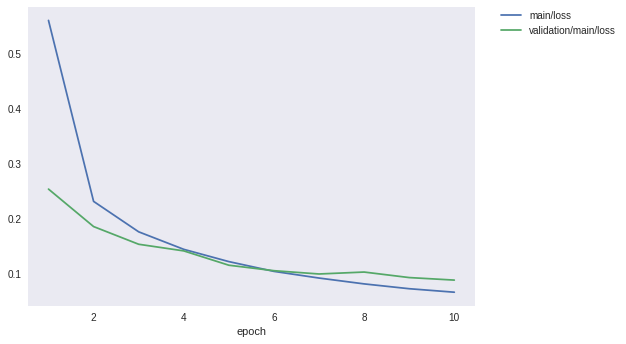

In [19]:
from IPython.display import Image
Image('mnist_result/loss.png')

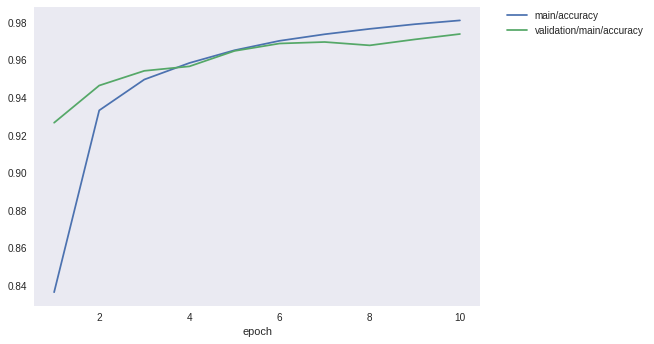

In [20]:
Image('mnist_result/accuracy.png')